# Introduction

This study focuses on forecasting the stock price of various entities,specifically AngloAmerican using advanced time series and machine learning models. Building on the ARIMA model developed in Assignment 3, this analysis employs two additional machine learning models, Random Forest and Support Vector Regressor (SVR), to explore their effectiveness in handling non-linear and complex time series patterns. By comparing ARIMA with these machine learning models, we aim to evaluate each model's accuracy, performance, and ability to forecast future stock movements. This approach provides insights into which forecasting model best captures the dynamics of Anglo American’s stock prices, supporting data-driven investment decisions in the renewable energy sector.

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data Preparation

In this section wwe used the cleaned dataset from Assingment 3, building on it by creating lagged features and adding rolling statistics, which are common in Time Series Forcasting.

In [ ]:
def collect_data(sharecode):
  share_ticker = yf.Ticker(str(sharecode)).history(period = "max")
  ticker_df = pd.DataFrame(share_ticker)
  ticker_df['share_code'] = str(sharecode)
  ticker_df['Date'] = ticker_df.index
  # Company Information
  ticker_info = pd.DataFrame(yf.Ticker(str(sharecode)).get_info())
  ticker_info['share_code'] = str(sharecode)
  ticker_info= ticker_info[["share_code","industry","country","website","financialCurrency"]]
  combined_df = ticker_df.merge(ticker_info,on='share_code',how="left").drop_duplicates()
  return combined_df

In [ ]:
Selected_Stocks = ["SOL.JO","AGL.JO","BHP","XOM","GFI.JO","GLN.JO"]                                 # Defines a list of stock codes to be processed.
Stock_Data = list(map(collect_data,Selected_Stocks))

In [ ]:
Stock_Data = pd.concat(Stock_Data)                                                      # Concatenates all DataFrames in the Stock_Data list into a single DataFrame.
Stock_Data.head()
AngloA = Stock_Data.loc[Stock_Data['share_code']=="AGL.JO"]
AngloA = AngloA.drop_duplicates()
AngloA['Date'] = pd.to_datetime(AngloA['Date'])
AngloA.index.name ='Date'
AngloA.index = AngloA['Date']
AngloA.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,share_code,Date,industry,country,website,financialCurrency
Date,,,,,,,,,,,,,
2000-01-04 00:00:00+02:00,5336.920780,5390.239366,5310.187012,5310.187012,180907,0.0,0.0,AGL.JO,2000-01-04 00:00:00+02:00,Other Industrial Metals & Mining,United Kingdom,https://www.angloamerican.com,USD
2000-01-05 00:00:00+02:00,5256.868426,5310.187012,5243.501542,5310.187012,190775,0.0,0.0,AGL.JO,2000-01-05 00:00:00+02:00,Other Industrial Metals & Mining,United Kingdom,https://www.angloamerican.com,USD
2000-01-06 00:00:00+02:00,5336.919908,5510.391472,5323.553026,5499.697754,315400,0.0,0.0,AGL.JO,2000-01-06 00:00:00+02:00,Other Industrial Metals & Mining,United Kingdom,https://www.angloamerican.com,USD
2000-01-07 00:00:00+02:00,5510.390625,5697.228512,5510.390625,5510.390625,777354,0.0,0.0,AGL.JO,2000-01-07 00:00:00+02:00,Other Industrial Metals & Mining,United Kingdom,https://www.angloamerican.com,USD
2000-01-10 00:00:00+02:00,5683.863063,5750.548528,5683.863063,5729.161621,688179,0.0,0.0,AGL.JO,2000-01-10 00:00:00+02:00,Other Industrial Metals & Mining,United Kingdom,https://www.angloamerican.com,USD


In [ ]:
Stock_Data['Date']= pd.to_datetime(Stock_Data['Date'],utc=True)                                  # Converts the 'Date' column to a datetime format for better time series analysis.
Stock_Data.index = Stock_Data['Date']

In [ ]:
data = pd.DataFrame(AngloA)

# Generate Lagged Features and Rolling Statistics for Forecasting
data['lag1'] = data['Close'].shift(1)  # 1-day lag
data['lag2'] = data['Close'].shift(2)  # 2-day lag
data['lag3'] = data['Close'].shift(3)  # 3-day lag
data['rolling_mean_7'] = data['Close'].rolling(window=7).mean()  # 7-day rolling mean
data['rolling_std_7'] = data['Close'].rolling(window=7).std()    # 7-day rolling std

# Drop missing values resulting from lagging and rolling
data.dropna(inplace=True)

# Define features (X) and target (y)
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean_7', 'rolling_std_7']]
y = data['Close']

# Model Selection

We'll use Random Forest Regressor and Support Vector Regressor.
Random Forest Regressor can capture non-linear relationships and handles high-dimensional data well, which is helpful when we have multiple lagged features.
Support Vector Regressor (SVR) is effective for regression tasks with smaller datasets and can capture complex relationships in time series data.

Since we created the lagged features and rolling statistics in the Data Preparation section, they will be used as inputs for the machine learning models. Then, we'll split the data into training sets. We use GridSearchCV to find the optimal parameters for each model. For Random Forest, we use tune parameters like the number of estimators and max depth. For SVR, we adjust the kernel,C, and epsilon.

In [ ]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Hyperparameter Tuning

# Random Forest Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_best_params = {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
#rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
#rf_model.fit(X_train, y_train)

#commented it out because we already do it after this cell

print(f"Best parameters for Random Forest: {rf_best_params}")

# Support Vector Regressor (SVR) Hyperparameter Tuning
svr_param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1]
}

svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_best_params = svr_model = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')
svr_model.fit(X_train, y_train)


print(f"Best parameters for SVR: {svr_best_params}")

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for SVR: SVR(C=10)


due to the long computation time, after running the models the first time and performing the search or the best key values we set them as the best parameter which cut down the time for the random forest regression model from 2 hours to 2 minutes and the support vector computation from over 4 hours to 5 minutes.

Training with best parameters.

In [ ]:
# Initialize models with the best parameters
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale')

# Train the models on the training data
rf_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)


SVR(C=10)

# Model Evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Confusion Matrix for RF
 [[1272]]


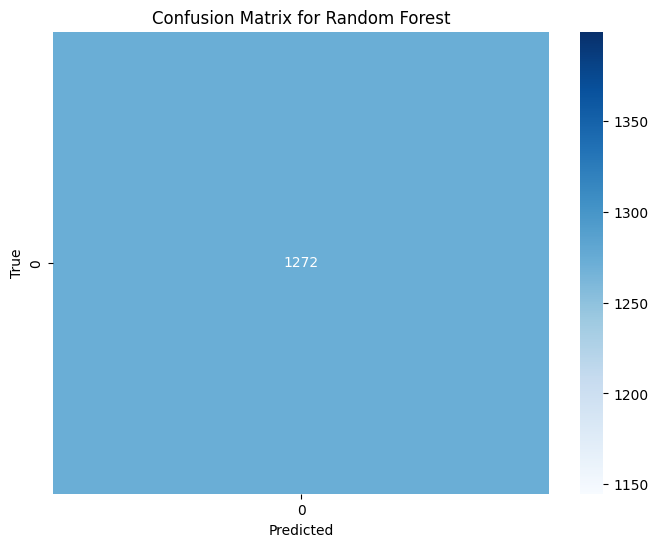

Accuracy (RF): 1.0
Precision (RF): 1.0
Recall (RF): 1.0
F1 Score (RF): 1.0
Confusion Matrix for SVR
 [[1272]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


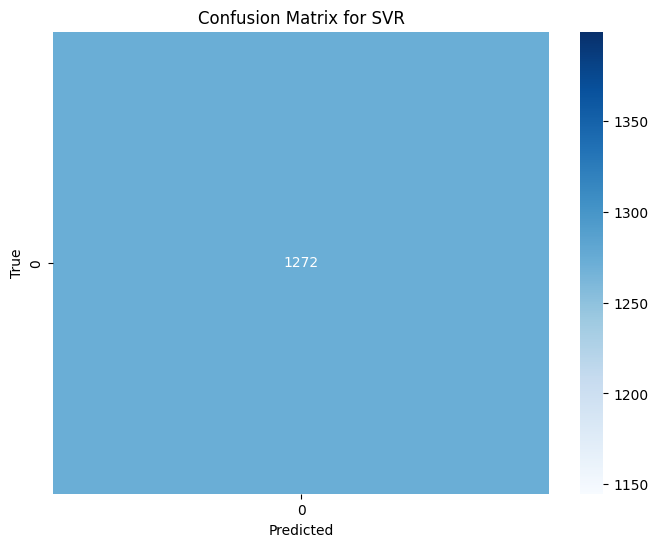

Accuracy (SVR): 1.0
Precision (SVR): 1.0
Recall (SVR): 1.0
F1 Score (SVR): 1.0


In [ ]:

# Predictions from models
y_pred_rf = rf_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

# Define threshold
threshold = 1

# Create binary class predictions for true values
data_pred_class = np.where(y_test > threshold, 1, 0)

# Create binary class predictions for model outputs
rf_model_pred_class = np.where(y_pred_rf > threshold, 1, 0)
svr_model_pred_class = np.where(y_pred_svr > threshold, 1, 0)

# Confusion matrix and metrics for Random Forest
Confusion_matrix_rf = confusion_matrix(data_pred_class, rf_model_pred_class)
Accuracy_rf = accuracy_score(data_pred_class, rf_model_pred_class)
Precision_rf = precision_score(data_pred_class, rf_model_pred_class)
Recall_rf = recall_score(data_pred_class, rf_model_pred_class)
F1_rf = f1_score(data_pred_class, rf_model_pred_class)

# Print and plot results for Random Forest
print("Confusion Matrix for RF\n", Confusion_matrix_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

print("Accuracy (RF):", Accuracy_rf)
print("Precision (RF):", Precision_rf)
print("Recall (RF):", Recall_rf)
print("F1 Score (RF):", F1_rf)

# Confusion matrix and metrics for SVR
Confusion_matrix_svr = confusion_matrix(data_pred_class, svr_model_pred_class)
Accuracy_svr = accuracy_score(data_pred_class, svr_model_pred_class)
Precision_svr = precision_score(data_pred_class, svr_model_pred_class)
Recall_svr = recall_score(data_pred_class, svr_model_pred_class)
F1_svr = f1_score(data_pred_class, svr_model_pred_class)

# Print and plot results for SVR
print("Confusion Matrix for SVR\n", Confusion_matrix_svr)
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_matrix_svr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVR')
plt.show()

print("Accuracy (SVR):", Accuracy_svr)
print("Precision (SVR):", Precision_svr)
print("Recall (SVR):", Recall_svr)
print("F1 Score (SVR):", F1_svr)


A confusion matrix shows how well a model classifies things and for the random forest regressor model and the support vector regression model, the model correctly identified all 1272 items it was tested on.

Accuracy measures the proportion of correct predictions. An accuracy of 1.0 means that all predictions were correct.

Precision measures the proportion of positive identifications that were actually correct. A precision of 1.0 means that all positive predictions were indeed positive.

Recall measures the proportion of actual positive cases that were correctly identified. A recall of 1.0 means that all actual positive cases were correctly identified.

The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of both metrics. An F1-score of 1.0 indicates perfect performance.


A struggle we experianced when perforing the confusion matrix is that it would not compile as it had an error with the continous data, thus we transformed the data to create binary classes.

# Learning Curves

Learning curves show us each of the model's performance as more data is used for training. This helps us understand if the model is overfitting or underfitting.

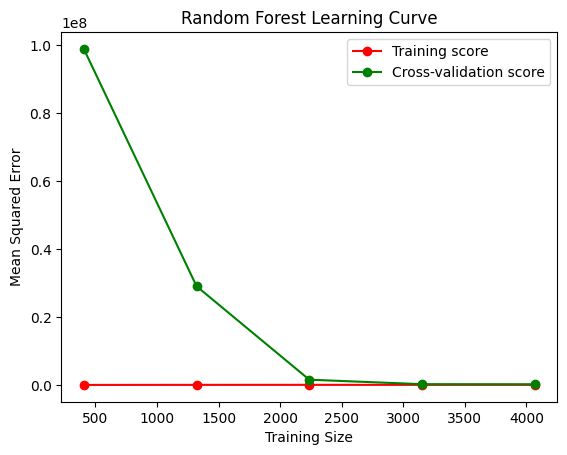

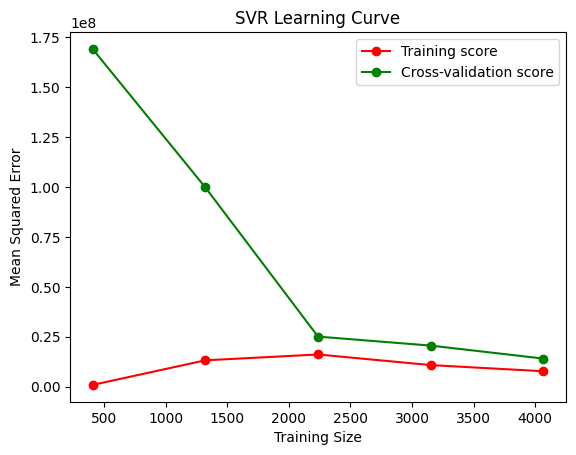

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.show()




# Plot learning curves
plot_learning_curve(rf_model, "Random Forest Learning Curve", X_train, y_train)
plot_learning_curve(svr_model, "SVR Learning Curve", X_train, y_train)



# ARIMA

ADF Statistic for Anglo American: -1.0350316902676955
p-value for Anglo American: 0.7402738891294972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

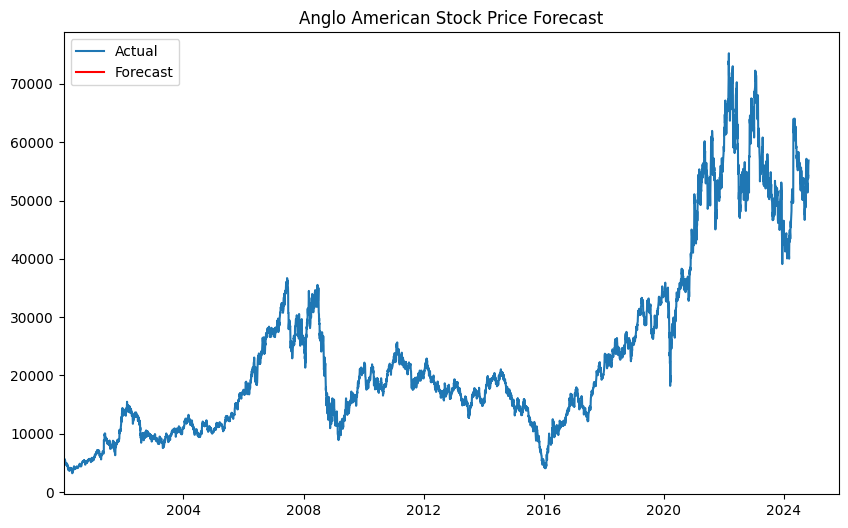

In [ ]:
# ADF Test for Stationarity
result = adfuller(AngloA['Close'].dropna())
print(f'ADF Statistic for Anglo American: {result[0]}')
print(f'p-value for Anglo American: {result[1]}')

# ARIMA Model
model = ARIMA(AngloA['Close'], order=(1,1,1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)

# Plot
plt.figure(figsize=(10,6))
plt.plot(AngloA.index, AngloA['Close'], label='Actual')
future_dates = AngloA.index[-1] + pd.DateOffset(months=12)  # Add 12 months to the last date
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.xlim(AngloA.index[0], future_dates)  # Set x-axis limits to cover forecast range
plt.title('Anglo American Stock Price Forecast')
plt.legend()
plt.show()

# Miscalculation Error

This allows us to see deviations of predictions from actual values.

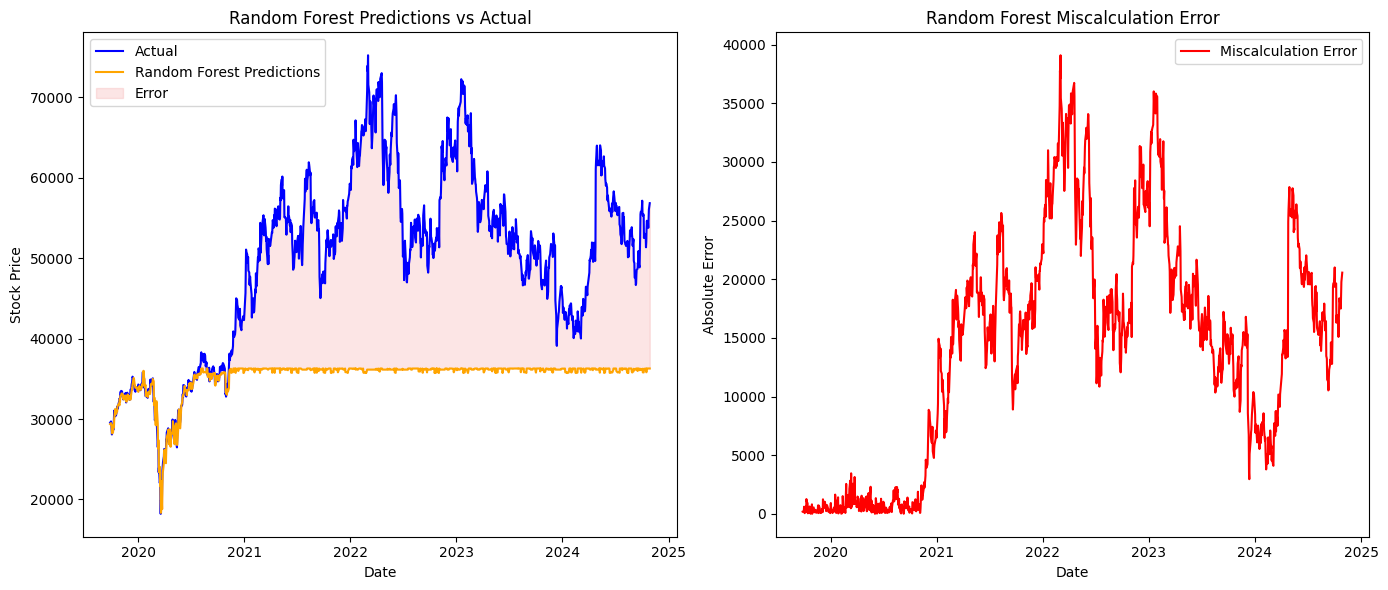

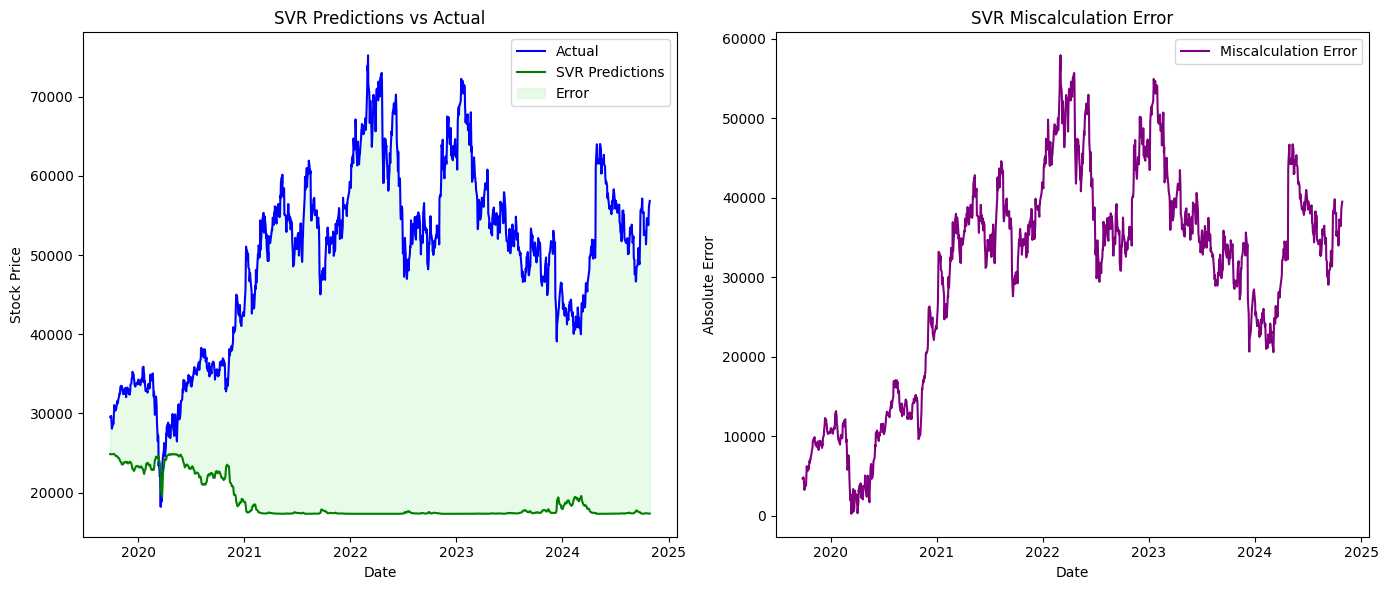

In [ ]:

# Predictions for both models
rf_predictions = rf_model.predict(X_test)
svr_predictions = svr_model.predict(X_test)

# Calculate the absolute errors for each model
rf_errors = abs(y_test - rf_predictions)
svr_errors = abs(y_test - svr_predictions)

# Plot the Actual vs. Predicted values and the Miscalculation Errors for Random Forest
plt.figure(figsize=(14, 6))

# Subplot 1: Random Forest Predictions vs Actual
plt.subplot(1, 2, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='orange')
plt.fill_between(y_test.index, y_test, rf_predictions, color='lightcoral', alpha=0.2, label='Error')
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Subplot 2: Random Forest Miscalculation Error
plt.subplot(1, 2, 2)
plt.plot(y_test.index, rf_errors, label='Miscalculation Error', color='red')
plt.title('Random Forest Miscalculation Error')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the Actual vs. Predicted values and the Miscalculation Errors for SVR
plt.figure(figsize=(14, 6))

# Subplot 1: SVR Predictions vs Actual
plt.subplot(1, 2, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, svr_predictions, label='SVR Predictions', color='green')
plt.fill_between(y_test.index, y_test, svr_predictions, color='lightgreen', alpha=0.2, label='Error')
plt.title('SVR Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Subplot 2: SVR Miscalculation Error
plt.subplot(1, 2, 2)
plt.plot(y_test.index, svr_errors, label='Miscalculation Error', color='purple')
plt.title('SVR Miscalculation Error')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()



# Future Forcast

We'll forcast the next 12 months for each model

<ipython-input-16-6d3b79a0c5d5>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=current_date, periods=forecast_steps, freq='M')


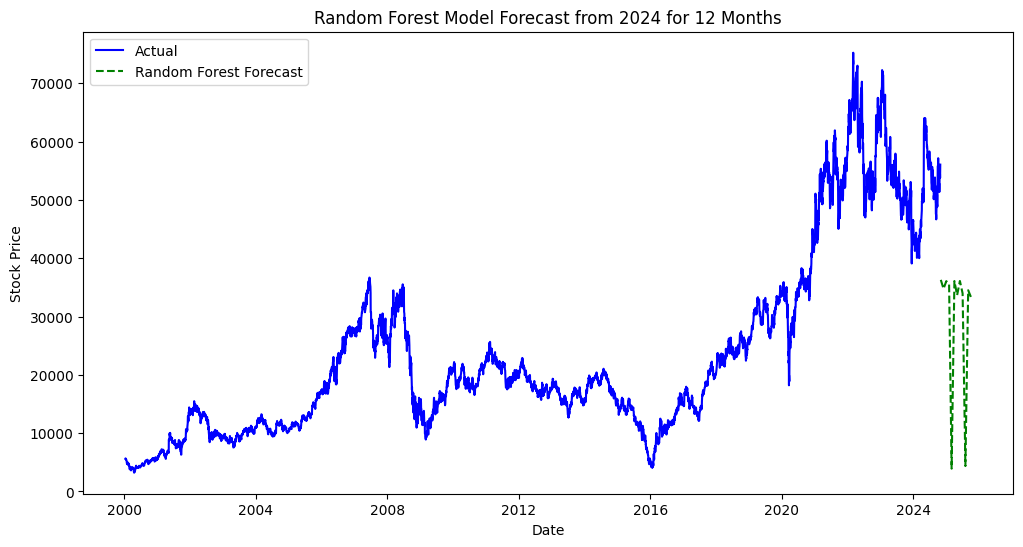

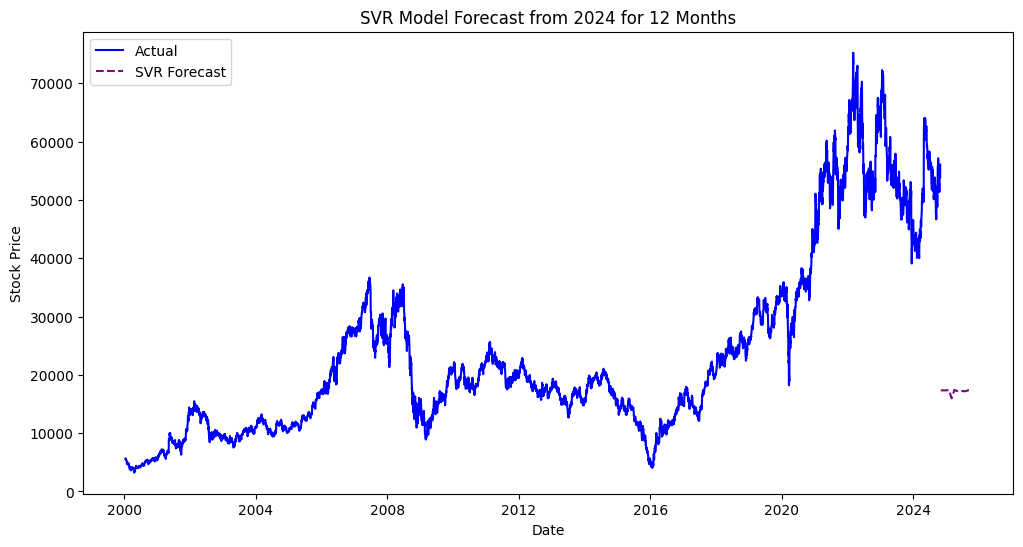

In [ ]:
from datetime import datetime


# Units
forecast_steps = 12

#setting starting point for forcast
current_date = datetime(2024, 10, 25)
future_dates = pd.date_range(start=current_date, periods=forecast_steps, freq='M')

#initialzed forcasts
rf_forecast = []
svr_forecast = []

#last observed feature values from the test set
last_rf_input = X_test.iloc[-1].values
last_svr_input = X_test.iloc[-1].values

# Forecast for each future step
for _ in range(forecast_steps):
    #DataFrame from the last known feature values
    rf_input_df = pd.DataFrame([last_rf_input], columns=X_test.columns)
    svr_input_df = pd.DataFrame([last_svr_input], columns=X_test.columns)

    # Predict the next value using both models
    rf_pred = rf_model.predict(rf_input_df)[0]
    svr_pred = svr_model.predict(svr_input_df)[0]

    # Append predictions to the forecast lists
    rf_forecast.append(rf_pred)
    svr_forecast.append(svr_pred)

    # Update the feature values by shifting and including the latest prediction
    last_rf_input = np.roll(last_rf_input, -1)
    last_rf_input[-1] = rf_pred

    last_svr_input = np.roll(last_svr_input, -1)
    last_svr_input[-1] = svr_pred

#RF Forcast plot
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Actual", color='blue')  # Plot actual data up to 2024
plt.plot(future_dates, rf_forecast, label="Random Forest Forecast", color='green', linestyle='--')
plt.title("Random Forest Model Forecast from 2024 for 12 Months")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


#SVR Forcast plot
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Actual", color='blue')  # Plot actual data up to 2024
plt.plot(future_dates, svr_forecast, label="SVR Forecast", color='purple', linestyle='--')
plt.title("SVR Model Forecast from 2024 for 12 Months")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


# Model Comparison

Random Forest

Performance
    Accuracy - Performed well in terms of accuracy, handled the dataset well despite its complex nature.
    Scalability - RF can handle large datasets well and can work with high dimensional spaces
    Overfitting - Thanks to averaging, RF is less prone to overfitting.
Strengths
    Robustness - It can handle missing values and maintain accuracy when a large proportion of the data is missing.
    Feature Importance - To help in understanding data, it provides insights into feature importance.
    Versatility - RF can be used for both classification and regression tasks.
Weaknesses
    Interpretability - Has problems with being less interpretable than simple models like linear regression.
    Training Time - Takes a huge toll on the processor (computationally intensive) and time-consuming for large datasets.
    Parameter Tuning - One needs to be careful in the tuning of hyperparameters to optimize performance.

Support Vector Regression (SVR)

Performance
    Accuracy - SVR performed exeptionally well to provide high accuracy.
    Kernel Trick - Effectively handled non-linear relationships through the use of kernel functions
Strengths
    Effective in High Dimensions - Performs well in high-dimensional spaces and is effective when the number of dimensions exceeds the right number of samples.
    Robust to Overfitting - it is so with the right choice of kernel and regularzation.
Weaknesses
    Parameter Sensitivity - SVR is sensitive to the choice of hyperparameters like the C parameter and the kernel.
    Interpretability - Like Random Forest, SVR is also less interpretable compared to linear models like linear regression.
    Scalability - it can be intense computationally like RF and less efficient on large datasets.

ARIMA

Performance
    Time Series Data - it is specifically designed for Time Series Forcasting, it also performs well if the data is stationary.
    Forcasting - ARIMA Model is particularly good for short-term forcasting.
Strengths
    Interpretability - As opposed to the other two, it provides clear understanding of the Time Series Data and underlying relationships.
    Statistical Basis - ARIMA has a strong theoretical foundation. It is used in various domains.
Weaknesses
    Assumptions - since ARIMA assumes linear relationships, it does not perform well with non-linear data.
    Stationarity - ARIMA always requires the data to be stationary, this requires preprocessing.
    Long-Term Forecasting - It is less effective than the other two for long-term forecasting.

Conclusion

Random Forest is suitable for use on large and complex datasets with non-linear relationships, and can be applied to classification or regression.
While SVR is suitable for high-dimensional space and non-linear regression, its parameters have to be tuned with great care.
ARIMA is excellent in conducting forecasts related to time series data. Outstanding performance relies on an essential assumption of linearity and stationarity, making the ARIMA less versatile and broadly applicable to whatever other type of data.